In [1]:
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
import ta
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime, timedelta

In [2]:
# Download stock data
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Calculate similarity between two time series
def calculate_similarity(current_data, past_data):
    min_length = min(len(current_data), len(past_data))
    current_data = current_data[:min_length]
    past_data = past_data[:min_length]
    
    # Normalize the data
    current_data = (current_data - np.mean(current_data)) / np.std(current_data)
    past_data = (past_data - np.mean(past_data)) / np.std(past_data)
    
    return mean_squared_error(current_data, past_data)



# Calibrate indicators
def calibrate_indicators(data, rsi_window, sma_window, ema_window,bollinger_window, stoch_window):
    data['RSI'] = ta.momentum.RSIIndicator(data['Close'], rsi_window).rsi()
    data['SMA'] = ta.trend.sma_indicator(data['Close'], sma_window)
    data['EMA'] = ta.trend.EMAIndicator(data['Close'], ema_window).ema_indicator()
    data['Bollinger'] = ta.volatility.BollingerBands(data['Close'], bollinger_window).bollinger_mavg()
    data['Stochastic'] = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'], stoch_window).stoch()



def find_similar_periods(ticker, current_start_date, current_end_date, past_start_year, past_end_year, step_months, top_n=5):
    current_data = get_stock_data(ticker, current_start_date, current_end_date)
    
    similar_periods = {}
    
    for year in range(past_start_year, past_end_year + 1):
        for month in range(1, 13, step_months):
            start_date = pd.Timestamp(year=year, month=month, day=1)
            end_date = start_date + pd.DateOffset(months=step_months)  


            print(f"Checking period {start_date} to {end_date}")
            
            if end_date > current_end_date:
                continue
            
            try:
                past_data = get_stock_data(ticker, start_date, end_date)
                similarity_score = calculate_similarity(current_data['Close'], past_data['Close'])
                similar_periods[(start_date, end_date)] = (similarity_score, (start_date, end_date))
            except Exception as e:
                print(f"Failed to get data for period {start_date} to {end_date}: {e}")
    
    ranked_periods = sorted(similar_periods.items(), key=lambda x: x[1][0])
    
    return [x[1][1] for x in ranked_periods[:top_n]]

has_been_called = False

def calculate_profit(actual_data, predicted_data, indicator, init_price):
    # use plot to show the actual and predicted data
    start_index = predicted_data.first_valid_index()

    # Synchronize actual_data with predicted_data
    actual_data = actual_data.loc[start_index:]

    global has_been_called

    if not has_been_called:
        plt.title(indicator)
        plt.plot(actual_data, label='Actual')
        plt.plot(predicted_data, label='Predicted')
        plt.legend()
        plt.show()
        has_been_called = True

    # Calculate the profit
    profit = 0
    bought = False
    money_left = init_price

    # Moving Average
    short_term_ma = predicted_data.rolling(window=5).mean()
    long_term_ma = predicted_data.rolling(window=20).mean()

    # RSI
    delta = predicted_data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    average_gain = up.rolling(window=14).mean()
    average_loss = abs(down.rolling(window=14).mean())
    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))

    # Bollinger Bands
    sma = predicted_data.rolling(window=20).mean()
    std = predicted_data.rolling(window=20).std()
    upper_bb = sma + (2 * std)
    lower_bb = sma - (2 * std)

    # Stochastic Oscillator
    low_min  = predicted_data.rolling( window = 14 ).min()
    high_max = predicted_data.rolling( window = 14 ).max()
    k = 100 * (predicted_data - low_min) / (high_max - low_min)
    d = k.rolling(window = 3).mean()

    for i in range(1, len(actual_data)):
        # Buy signal
        if (short_term_ma.iloc[i] > long_term_ma.iloc[i] or rsi.iloc[i] < 30 or predicted_data.iloc[i] < lower_bb.iloc[i] or k.iloc[i] < 20) and money_left >= actual_data.iloc[i]:
            stocks_to_buy = money_left // actual_data.iloc[i]  # Calculate how many stocks to buy
            bought += stocks_to_buy  # Buy the stocks
            money_spent = stocks_to_buy * actual_data.iloc[i]
            profit -= money_spent
            money_left -= money_spent  # Deduct the money spent from the money left
        # Sell signal
        elif (short_term_ma.iloc[i] < long_term_ma.iloc[i] or rsi.iloc[i] > 70 or predicted_data.iloc[i] > upper_bb.iloc[i] or k.iloc[i] > 80) and bought > 0:
            money_earned = bought * actual_data.iloc[i]  # Sell all the stocks
            profit += money_earned
            money_left += money_earned  # Add the money earned to the money left
            bought = 0  # Reset the number of stocks bought
    if bought > 0:
        money_earned = bought * actual_data.iloc[-1]  # Sell all the stocks
        profit += money_earned
        money_left += money_earned  # Add the money earned to the money left

    # Calculate the final price
    final_price = init_price + profit

    # Calculate return
    return_rate = profit / init_price

    # Calculate Sharpe ratio
    excess_returns = predicted_data.pct_change().dropna()
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)

    return profit, final_price, return_rate, sharpe_ratio



# Predict prices using the single-period SMA
def predict_prices(data, sma_window):
    data['SMA'] = ta.trend.sma_indicator(data['Close'], sma_window)
    predicted_prices = data['SMA']  # Use the single-period SMA directly
    return predicted_prices

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Checking period 2014-01-01 00:00:00 to 2014-04-01 00:00:00
Checking period 2014-04-01 00:00:00 to 2014-07-01 00:00:00
Checking period 2014-07-01 00:00:00 to 2014-10-01 00:00:00


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Checking period 2014-10-01 00:00:00 to 2015-01-01 00:00:00
Checking period 2015-01-01 00:00:00 to 2015-04-01 00:00:00


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Checking period 2015-04-01 00:00:00 to 2015-07-01 00:00:00
Checking period 2015-07-01 00:00:00 to 2015-10-01 00:00:00
Checking period 2015-10-01 00:00:00 to 2016-01-01 00:00:00


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Checking period 2016-01-01 00:00:00 to 2016-04-01 00:00:00
Checking period 2016-04-01 00:00:00 to 2016-07-01 00:00:00
Checking period 2016-07-01 00:00:00 to 2016-10-01 00:00:00


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Checking period 2016-10-01 00:00:00 to 2017-01-01 00:00:00
Checking period 2017-01-01 00:00:00 to 2017-04-01 00:00:00
Checking period 2017-04-01 00:00:00 to 2017-07-01 00:00:00


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Checking period 2017-07-01 00:00:00 to 2017-10-01 00:00:00
Checking period 2017-10-01 00:00:00 to 2018-01-01 00:00:00
Checking period 2018-01-01 00:00:00 to 2018-04-01 00:00:00


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Checking period 2018-04-01 00:00:00 to 2018-07-01 00:00:00
Checking period 2018-07-01 00:00:00 to 2018-10-01 00:00:00
Checking period 2018-10-01 00:00:00 to 2019-01-01 00:00:00


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Checking period 2019-01-01 00:00:00 to 2019-04-01 00:00:00
Checking period 2019-04-01 00:00:00 to 2019-07-01 00:00:00
Checking period 2019-07-01 00:00:00 to 2019-10-01 00:00:00


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Checking period 2019-10-01 00:00:00 to 2020-01-01 00:00:00
Checking period 2020-01-01 00:00:00 to 2020-04-01 00:00:00
Checking period 2020-04-01 00:00:00 to 2020-07-01 00:00:00


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Checking period 2020-07-01 00:00:00 to 2020-10-01 00:00:00
Checking period 2020-10-01 00:00:00 to 2021-01-01 00:00:00
Checking period 2021-01-01 00:00:00 to 2021-04-01 00:00:00


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Checking period 2021-04-01 00:00:00 to 2021-07-01 00:00:00
Checking period 2021-07-01 00:00:00 to 2021-10-01 00:00:00
Checking period 2021-10-01 00:00:00 to 2022-01-01 00:00:00


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Checking period 2022-01-01 00:00:00 to 2022-04-01 00:00:00
Checking period 2022-04-01 00:00:00 to 2022-07-01 00:00:00
Checking period 2022-07-01 00:00:00 to 2022-10-01 00:00:00


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Checking period 2022-10-01 00:00:00 to 2023-01-01 00:00:00
Checking period 2023-01-01 00:00:00 to 2023-04-01 00:00:00
Checking period 2023-04-01 00:00:00 to 2023-07-01 00:00:00


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Checking period 2023-07-01 00:00:00 to 2023-10-01 00:00:00
Checking period 2023-10-01 00:00:00 to 2024-01-01 00:00:00
Checking period 2024-01-01 00:00:00 to 2024-04-01 00:00:00


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Checking period 2024-04-01 00:00:00 to 2024-07-01 00:00:00
Checking period 2024-07-01 00:00:00 to 2024-10-01 00:00:00
Checking period 2024-10-01 00:00:00 to 2025-01-01 00:00:00
Similar periods: [(Timestamp('2016-04-01 00:00:00'), Timestamp('2016-07-01 00:00:00')), (Timestamp('2018-10-01 00:00:00'), Timestamp('2019-01-01 00:00:00')), (Timestamp('2023-07-01 00:00:00'), Timestamp('2023-10-01 00:00:00')), (Timestamp('2022-04-01 00:00:00'), Timestamp('2022-07-01 00:00:00')), (Timestamp('2015-07-01 00:00:00'), Timestamp('2015-10-01 00:00:00'))]



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Average SMA profit                                |     -21.24
Average RSI profit                                |      23.90
Average EMA profit                                |      -2.43
Average Bollinger Bands profit                    |     -21.24
Average Stochastic Oscillator profit              |      18.08

Average SMA final price                           |     978.76
Average RSI final price                           |    1023.90
Average EMA final price                           |     997.57
Average Bollinger Bands final price               |     978.76
Average Stochastic Oscillator final price         |    1018.08

Average SMA return rate                           |   -0.02124
Average RSI return rate                           |    0.02390
Average EMA return rate                           |   -0.00243
Average Bollinger Bands return rate               |   -0.02124
Average Stochastic Oscillator return rate         |    0.01808

Average SMA Sharpe ratio                          | 

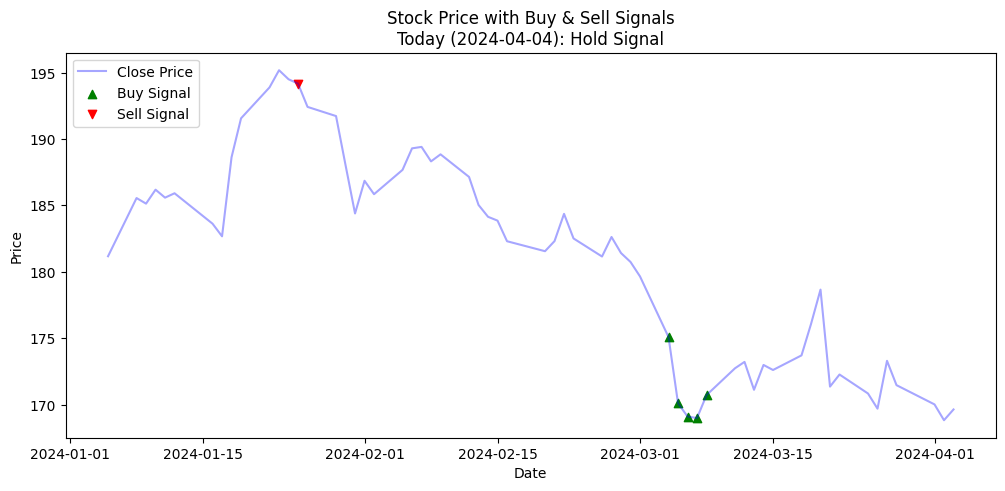

In [6]:
# Example usage
ticker_symbol = input("Enter the ticker symbol: ")
# The current_start and current_end should be user input
current_start = pd.Timestamp(year=2023, month=12, day=1)

endYear = datetime.now().year
endMonth = datetime.now().month
endDay = datetime.now().day

current_end = pd.Timestamp(year=endYear, month=endMonth, day=endDay)
past_start_year = endYear - 10
past_end_year = endYear
step_months = 3

# Calibrate indicators
rsi_window = 14
sma_window = 20
ema_window = 12
bollinger_window = 20
stoch_window = 14
init_price = 1000

sma_profits = []
rsi_profits = []
ema_profits = []
bollinger_profits = []
stoch_profits = []

sma_final_prices = []
rsi_final_prices = []
ema_final_prices = []
bollinger_final_prices = []
stoch_final_prices = []

# Initialize lists for return rates
sma_return_rates = []
rsi_return_rates = []
ema_return_rates = []
bollinger_return_rates = []
stoch_return_rates = []

# Initialize list for sharpe ratios
sma_sharpe_ratios = []
rsi_sharpe_ratios = []
ema_sharpe_ratios = []
bollinger_sharpe_ratios = []
stoch_sharpe_ratios = []



similar_periods = find_similar_periods(ticker_symbol, current_start, current_end, past_start_year, past_end_year, step_months)
print(f"Similar periods: {similar_periods}\n")
for i, period in enumerate(similar_periods, 1):
    # Fetch the data for the two periods
    data_current = get_stock_data(ticker_symbol, current_start, current_end)
    data_similar = get_stock_data(ticker_symbol, period[0], period[1])
    # Calibrate indicators
    calibrate_indicators(data_similar, rsi_window, sma_window, ema_window,bollinger_window, stoch_window)

    # Define future_start and future_end (3 month)
    future_start = period[1]
    future_end = future_start + pd.DateOffset(months=3)

    # Evaluate performance with past future periods
    future_data = get_stock_data(ticker_symbol, future_start, future_end)
    calibrate_indicators(future_data, rsi_window, sma_window, ema_window, bollinger_window, stoch_window)

    predicted_prices = predict_prices(future_data, sma_window)
    actual_prices = future_data['Close']

    #    return profit,return_rate, sharpe_ratio, final_price

    
    # Inside the loop
    sma_profit, sma_final_price,sma_return_rate,sma_sharpe_ratio = calculate_profit(actual_prices, predicted_prices, "SMA", init_price)
    rsi_profit, rsi_final_price, rsi_return_rate,rsi_sharpe_ratio = calculate_profit(actual_prices, future_data['RSI'], "RSI", init_price)
    ema_profit, ema_final_price, ema_return_rate, ema_sharpe_ratio = calculate_profit(actual_prices, future_data['EMA'], "EMA", init_price)
    bollinger_profit, bollinger_final_price, bollinger_return_rate, bollinger_sharpe_ratio = calculate_profit(actual_prices, future_data['Bollinger'], "Bollinger", init_price)
    stoch_profit, stoch_final_price, stoch_return_rate, stoch_sharpe_ratio = calculate_profit(actual_prices, future_data['Stochastic'], "Stochastic", init_price)
    # Append profits and final prices to the respective lists
    sma_profits.append(sma_profit)
    rsi_profits.append(rsi_profit)
    ema_profits.append(ema_profit)
    bollinger_profits.append(bollinger_profit)
    stoch_profits.append(stoch_profit)

    sma_final_prices.append(sma_final_price)
    rsi_final_prices.append(rsi_final_price)
    ema_final_prices.append(ema_final_price)
    bollinger_final_prices.append(bollinger_final_price)
    stoch_final_prices.append(stoch_final_price)

    # Append return rates to the respective lists
    sma_return_rates.append(sma_return_rate)
    rsi_return_rates.append(rsi_return_rate)
    ema_return_rates.append(ema_return_rate)
    bollinger_return_rates.append(bollinger_return_rate)
    stoch_return_rates.append(stoch_return_rate)

    sma_sharpe_ratios.append(sma_sharpe_ratio)
    rsi_sharpe_ratios.append(rsi_sharpe_ratio)
    ema_sharpe_ratios.append(ema_sharpe_ratio)
    bollinger_sharpe_ratios.append(bollinger_sharpe_ratio)
    stoch_sharpe_ratios.append(stoch_sharpe_ratio)


# Calculate average profit and final price for each indicator
average_sma_profit = sum(sma_profits) / len(sma_profits)
average_rsi_profit = sum(rsi_profits) / len(rsi_profits)
average_ema_profit = sum(ema_profits) / len(ema_profits)
average_bollinger_profit = sum(bollinger_profits) / len(bollinger_profits)
average_stoch_profit = sum(stoch_profits) / len(stoch_profits)

average_sma_final_price = sum(sma_final_prices) / len(sma_final_prices)
average_rsi_final_price = sum(rsi_final_prices) / len(rsi_final_prices)
average_ema_final_price = sum(ema_final_prices) / len(ema_final_prices)
average_bollinger_final_price = sum(bollinger_final_prices) / len(bollinger_final_prices)
average_stoch_final_price = sum(stoch_final_prices) / len(stoch_final_prices)

average_sma_return_rate = sum(sma_return_rates) / len(sma_return_rates)
average_rsi_return_rate = sum(rsi_return_rates) / len(rsi_return_rates)
average_ema_return_rate = sum(ema_return_rates) / len(ema_return_rates)
average_bollinger_return_rate = sum(bollinger_return_rates) / len(bollinger_return_rates)
average_stoch_return_rate = sum(stoch_return_rates) / len(stoch_return_rates)

average_sma_sharpe_ratio = np.nanmean(sma_sharpe_ratios)
average_rsi_sharpe_ratio = np.nanmean(rsi_sharpe_ratios)
average_ema_sharpe_ratio = np.nanmean(ema_sharpe_ratios)
average_bollinger_sharpe_ratio = np.nanmean(bollinger_sharpe_ratios)
average_stoch_sharpe_ratio = np.nanmean(stoch_sharpe_ratios)

print(f'{"Average SMA profit":50s}| {average_sma_profit:10.2f}')
print(f'{"Average RSI profit":50s}| {average_rsi_profit:10.2f}')
print(f'{"Average EMA profit":50s}| {average_ema_profit:10.2f}')
print(f'{"Average Bollinger Bands profit":50s}| {average_bollinger_profit:10.2f}')
print(f'{"Average Stochastic Oscillator profit":50s}| {average_stoch_profit:10.2f}\n')

print(f'{"Average SMA final price":50s}| {average_sma_final_price:10.2f}')
print(f'{"Average RSI final price":50s}| {average_rsi_final_price:10.2f}')
print(f'{"Average EMA final price":50s}| {average_ema_final_price:10.2f}')
print(f'{"Average Bollinger Bands final price":50s}| {average_bollinger_final_price:10.2f}')
print(f'{"Average Stochastic Oscillator final price":50s}| {average_stoch_final_price:10.2f}\n')

print(f'{"Average SMA return rate":50s}| {average_sma_return_rate:10.5f}')
print(f'{"Average RSI return rate":50s}| {average_rsi_return_rate:10.5f}')
print(f'{"Average EMA return rate":50s}| {average_ema_return_rate:10.5f}')
print(f'{"Average Bollinger Bands return rate":50s}| {average_bollinger_return_rate:10.5f}')
print(f'{"Average Stochastic Oscillator return rate":50s}| {average_stoch_return_rate:10.5f}\n')

print(f'{"Average SMA Sharpe ratio":50s}| {average_sma_sharpe_ratio:10.2f}')
print(f'{"Average RSI Sharpe ratio":50s}| {average_rsi_sharpe_ratio:10.2f}')
print(f'{"Average EMA Sharpe ratio":50s}| {average_ema_sharpe_ratio:10.2f}')
print(f'{"Average Bollinger Bands Sharpe ratio":50s}| {average_bollinger_sharpe_ratio:10.2f}')
print(f'{"Average Stochastic Oscillator Sharpe ratio":50s}| {average_stoch_sharpe_ratio:10.2f}')

# Python
profits = [
    ("SMA", average_sma_profit),
    ("RSI", average_rsi_profit),
    ("EMA", average_ema_profit),
    ("Bollinger", average_bollinger_profit),
    ("Stochastic", average_stoch_profit)
]

# Sort the list in descending order based on the profit
profits.sort(key=lambda x: x[1], reverse=True)

# The first element in the sorted list is the best indicator
best_indicator = profits[0]


print(f"The best indicator is {best_indicator[0]} with a profit of {best_indicator[1]}")

if best_indicator[1] > 0:
    end_date = datetime.now()
    start_date = end_date - timedelta(days=90)  # Get data for the past year
    data = get_stock_data(ticker_symbol, start_date, end_date)

    rsi_window = 14
    sma_window = 20
    ema_window = 12
    bollinger_window = 20
    stoch_window = 14
    calibrate_indicators(data, rsi_window, sma_window, ema_window, bollinger_window, stoch_window)

    if best_indicator[0] == 'Stochastic':
        buy_signals = data['Stochastic'] < 20
        sell_signals = data['Stochastic'] > 80
    elif best_indicator[0] == 'SMA':
        buy_signals = data['SMA'] < data['Close']  # Adjust these conditions as needed
        sell_signals = data['SMA'] > data['Close']
    elif best_indicator[0] == 'RSI':
        buy_signals = data['RSI'] < 30
        sell_signals = data['RSI'] > 70
    elif best_indicator[0] == 'EMA':
        buy_signals = data['EMA'] < data['Close']  # Adjust these conditions as needed
        sell_signals = data['EMA'] > data['Close']
    elif best_indicator[0] == 'Bollinger':
        buy_signals = data['Close'] < data['Bollinger']  # Adjust these conditions as needed
        sell_signals = data['Close'] > data['Bollinger']

    buy_prices = data['Close'].where(buy_signals, None)
    sell_prices = data['Close'].where(sell_signals, None)

    plt.figure(figsize=(12,5))
    plt.plot(data['Close'], label='Close Price', color='blue', alpha=0.35)
    plt.scatter(data.index, buy_prices, color='green', label='Buy Signal', marker='^', alpha=1)
    plt.scatter(data.index, sell_prices, color='red', label='Sell Signal', marker='v', alpha=1)

    # Check if today is a buy or sell signal
    if buy_signals.iloc[-1]:
        plt.scatter(data.index[-1], data['Close'].iloc[-1], color='blue', label='Today: Buy Signal', marker='o', alpha=1)
        today_signal = 'Buy'
    elif sell_signals.iloc[-1]:
        plt.scatter(data.index[-1], data['Close'].iloc[-1], color='purple', label='Today: Sell Signal', marker='o', alpha=1)
        today_signal = 'Sell'
    else:
        today_signal = 'Hold'

    plt.title(f'Stock Price with Buy & Sell Signals\nToday ({end_date.strftime("%Y-%m-%d")}): {today_signal} Signal')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.savefig('predict.png')  # Save the plot as a PNG file
    plt.show()